## Read data

In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [3]:
print(os.listdir("../input"))

['resnet50', 'best-artworks-of-all-time']


In [4]:
artists = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
artists.shape

(50, 8)

In [5]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Data Processing

In [6]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 123].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.297560
1,Edgar Degas,702,0.371738
2,Pablo Picasso,439,0.594442
3,Pierre-Auguste Renoir,336,0.776667
4,Albrecht Dürer,328,0.795610
5,Paul Gauguin,311,0.839100
6,Francisco Goya,291,0.896770
7,Rembrandt,262,0.996031
8,Alfred Sisley,259,1.007568
9,Titian,255,1.023373


In [7]:
max(artists_top.class_weight)

2.071111111111111

In [8]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.29755986316989735,
 1: 0.37173789173789173,
 2: 0.5944419134396355,
 3: 0.7766666666666666,
 4: 0.795609756097561,
 5: 0.8390996784565916,
 6: 0.8967697594501718,
 7: 0.9960305343511451,
 8: 1.0075675675675675,
 9: 1.023372549019608,
 10: 1.0918828451882845,
 11: 1.3451546391752578,
 12: 1.3521243523316062,
 13: 1.3880851063829787,
 14: 1.403010752688172,
 15: 1.441767955801105,
 16: 1.5260818713450293,
 17: 1.591219512195122,
 18: 1.824895104895105,
 19: 1.8507801418439715,
 20: 1.877410071942446,
 21: 1.9048175182481752,
 22: 1.9474626865671643,
 23: 2.03875,
 24: 2.071111111111111}

In [9]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("Dürer", "Du╠êrer")
artists_top.iloc[4, 0] = updated_name

In [10]:
# Explore images of top artists
images_dir = '../input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> ../input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> ../input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> ../input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> ../input/best-artworks-of-all-time/images/images/Albrecht_Du╠êrer
Found --> ../input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> ../input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> ../input/best-artworks-of-all-time/images/images/Rembrandt
Found --> ../input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> ../input/best-artworks-of-all-time/images/images/Titian
Found --> ../input/best-artworks-of-all-time/images/images/Marc_Chagall
Found --> ../input/best-artworks-of-all-time/images/images/Rene_Magritte
Found --> ../input/best-artworks-of-all-time/images/images/Amedeo_Modigliani
Found --> ../input/best-artworks-of-all-time/im

### Print few random paintings

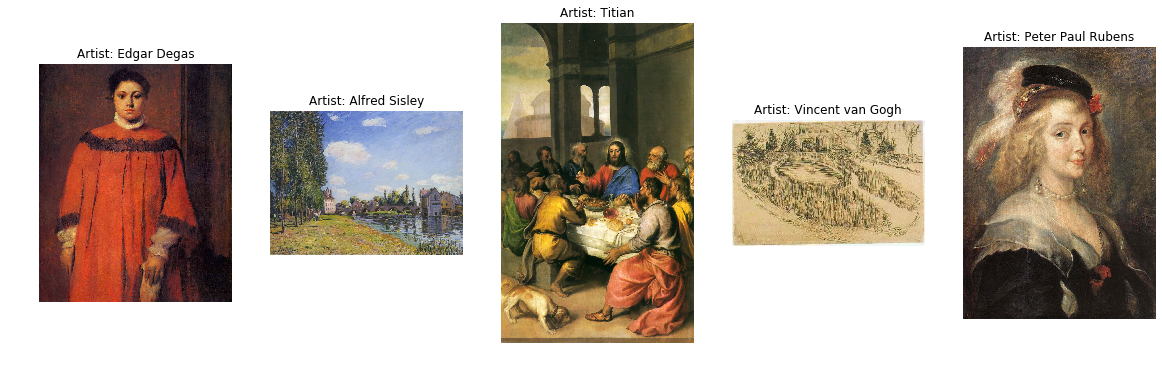

In [11]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation

In [12]:
artists_top_name

array(['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso',
       'Pierre-Auguste_Renoir', 'Albrecht_Du╠êrer', 'Paul_Gauguin',
       'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian',
       'Marc_Chagall', 'Rene_Magritte', 'Amedeo_Modigliani', 'Paul_Klee',
       'Henri_Matisse', 'Andy_Warhol', 'Mikhail_Vrubel',
       'Sandro_Botticelli', 'Leonardo_da_Vinci', 'Peter_Paul_Rubens',
       'Salvador_Dali', 'Hieronymus_Bosch', 'Pieter_Bruegel',
       'Diego_Velazquez', 'Kazimir_Malevich'], dtype=object)

In [13]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 5231 images belonging to 25 classes.
Found 1293 images belonging to 25 classes.
Total number of batches = 326 and 80


### Print a random paintings and it's random augmented version

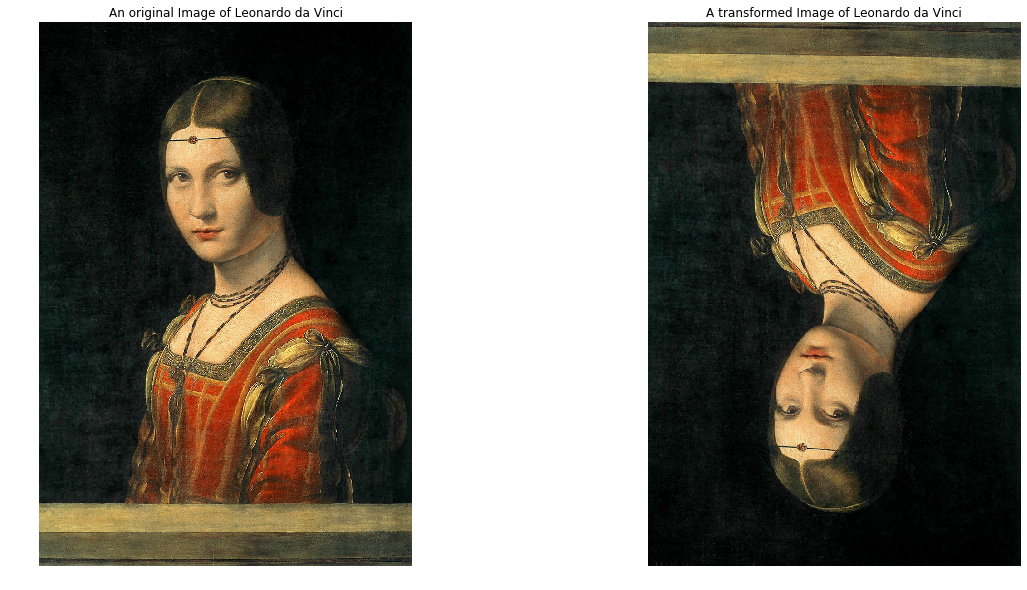

In [14]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Build Model

In [15]:
#VGG16
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False

Using TensorFlow backend.


58892288/58889256 [==============================] - 0s 0us/step


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

vgg16_model = Sequential()
vgg16_model.add(vgg16)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(units=25, activation='softmax'))
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

history_2 = vgg16_model.fit_generator(train_generator, epochs=50, steps_per_epoch=STEP_SIZE_TRAIN, 
                                 validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                 class_weight=class_weights)


test_loss_vgg, test_loss_vgg = vgg16_model.evaluate(valid_generator)


Epoch 1/50
326/326 [==============================] - 203s 624ms/step - loss: 2.6369 - acc: 0.2517 - val_loss: 2.2291 - val_acc: 0.3289
Epoch 2/50
326/326 [==============================] - 167s 511ms/step - loss: 1.8330 - acc: 0.4205 - val_loss: 1.8349 - val_acc: 0.4644
Epoch 3/50
326/326 [==============================] - 162s 496ms/step - loss: 1.5318 - acc: 0.5109 - val_loss: 2.0545 - val_acc: 0.4017
Epoch 4/50
326/326 [==============================] - 163s 499ms/step - loss: 1.3155 - acc: 0.5626 - val_loss: 1.8152 - val_acc: 0.4722
Epoch 5/50
326/326 [==============================] - 162s 498ms/step - loss: 1.1354 - acc: 0.6088 - val_loss: 1.8454 - val_acc: 0.4714
Epoch 6/50
326/326 [==============================] - 163s 501ms/step - loss: 1.0230 - acc: 0.6425 - val_loss: 1.8172 - val_acc: 0.5074
Epoch 7/50
326/326 [==============================] - 162s 496ms/step - loss: 0.9424 - acc: 0.6698 - val_loss: 1.8441 - val_acc: 0.5051
Epoch 8/50
326/326 [============================

In [45]:
test_loss_vgg, test_acc_vgg = vgg16_model.evaluate_generator(valid_generator,steps=1)
print(f'Test metrics for VGG16: Loss: {test_loss_vgg}, Accuracy: {test_acc_vgg}')

Test metrics for VGG16: Loss: 1.9628440141677856, Accuracy: 0.75
